# Dimensionality Reduction Example

Using the IMDB data, feature matrix and apply dimensionality reduction to this matrix via PCA and SVD.

In [1]:
%matplotlib inline

In [2]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter

from scipy.sparse import lil_matrix

from sklearn.neighbors import DistanceMetric

from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [3]:
# Let's restrict ourselves just to US titles
relevant_title_df = pd.read_csv("../data/us_relevant_titles.csv")

# And create a set of just these titles, so we can filter them
relevant_title_set = set(relevant_title_df["title"])

In [4]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_list = [] # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to American movies
        if this_movie["title_name"] not in relevant_title_set:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_list.append({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [5]:
print("Known Actors:", len(known_actors))

Known Actors: 161996


## Generate Same DataFrame using Sparse Matrics

The above will break if you have too much data. We can get around that partially with sparse matrices, where we only store the non-zero elements of the feature matrix and their indices.

In [6]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_list), len(known_actors)), dtype=bool)

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,movie in enumerate(movie_actor_list):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [7]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m["movie"] for m in movie_actor_list],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0001379,nm0000953,nm0864851,nm0933983,nm0329491,nm0000123,nm0000221,nm0307255,nm0635649,nm0033458,...,nm10823679,nm1290838,nm5580678,nm8370368,nm0578248,nm2952127,nm3611859,nm9445072,nm8594703,nm8680851
The Other Side of the Wind,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grizzly II: Revenge,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chief Zabu,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Life Without Sara Amat,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
The Rehearsal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
Safeguard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Coven,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
top_k_actors = 1000

In [9]:
# Extract the most frequent actors, so we can deal with a reasonable dataset size
actor_df = df.sum(axis=0)
top_actors = set(actor_df.sort_values().tail(top_k_actors).index)

In [10]:
# Restrict the data frame to just the movies containing
#. the top k actors
reduced_df = df[top_actors] # restrict to just these top actors

# throw away movies that don't have any of these actors
reduced_df = reduced_df.loc[reduced_df.sum(axis=1) > 0] 

reduced_df

,nm0004486,nm0900915,nm1307291,nm0185819,nm0728762,nm0648499,nm0919616,nm0469823,nm0786639,nm0244707,...,nm0265492,nm0437630,nm0001953,nm0482695,nm0000093,nm0497710,nm4574737,nm0000209,nm0541908,nm1693089
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply SVD to Feature Matrix

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.decomposition import TruncatedSVD 

In [12]:
matrix_dense = reduced_df.to_numpy()
reduced_df

,nm0004486,nm0900915,nm1307291,nm0185819,nm0728762,nm0648499,nm0919616,nm0469823,nm0786639,nm0244707,...,nm0265492,nm0437630,nm0001953,nm0482695,nm0000093,nm0497710,nm4574737,nm0000209,nm0541908,nm1693089
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
svd = TruncatedSVD(n_components=2)

In [14]:
svd.fit(matrix_dense)

TruncatedSVD()

In [15]:
matrix_reduced = svd.transform(matrix_dense)

In [16]:
np.mean(matrix_reduced, axis=0)

array([0.012321  , 0.00921186])

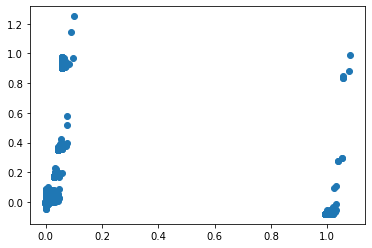

In [17]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1])

## Apply Clustering

We'll use AgglomerativeClustering from Sklearn to cluster this data.

In [18]:
from sklearn.cluster import KMeans

k = 4

model = KMeans(n_clusters=k)

In [19]:
model.fit(matrix_reduced)

KMeans(n_clusters=4)

In [20]:
reduced_df["cluster"] = model.labels_

In [21]:
reduced_df[["cluster"]]

,cluster
Grizzly II: Revenge,0
Crime and Punishment,0
For the Cause,0
Gang,0
In the Mood for Love,0
...,...
Fox Hunting,0
Mountain Quest,0
Enemy Lines,0
Manoharam,0


In [22]:
reduced_df["cluster"].value_counts()

0    18069
1      194
3      173
2       97
Name: cluster, dtype: int64

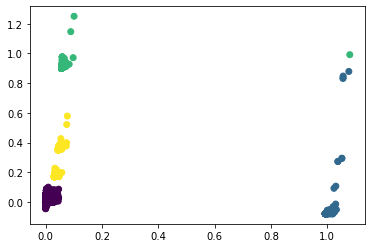

In [23]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1], c=reduced_df["cluster"])

In [24]:
for cluster,cluster_group in reduced_df.groupby("cluster"):
    print("Cluster:", cluster)
    
    sample_size = min(cluster_group.shape[0], 20)
    
    genre_counter = {}
    actor_counter = {}
    print("\t", "Movie Sample:")
    
    print_limit = 10
    for m in cluster_group.sample(n=sample_size).itertuples():
        if print_limit > 0:
            print("\t\t", m[0])
        print_limit -= 1
        
        this_movie_match = [movie for movie in movie_actor_list if movie["movie"] == m[0]]
        for movie in this_movie_match:
            for g in movie["genres"]:
                genre_counter[g] = genre_counter.get(g, 0) + 1
            for g in movie["actors"]:
                actor_counter[g] = actor_counter.get(g, 0) + 1
    
    print("\t", "Genres:")
    for g in sorted(genre_counter, key=genre_counter.get, reverse=True)[:10]:
        print("\t\t", g, genre_counter[g])
    print("\t", "Actors:")
    for a in sorted(actor_counter, key=actor_counter.get, reverse=True)[:10]:
        print("\t\t", actor_id_to_name_map[a], actor_counter[a])
    


Cluster: 0
	 Movie Sample:
		 Hope
		 Werewolf Rising
		 Bhoothnath
		 Feel Good
		 Silent Night
		 What They Had
		 Rogue One: A Star Wars Story
		 Maixabel
		 Mind Games
		 Collar Bomb
	 Genres:
		 Drama 23
		 Comedy 9
		 Adventure 8
		 Action 8
		 Thriller 7
		 Horror 6
		 Crime 5
		 Documentary 4
		 Biography 3
		 History 3
	 Actors:
		 D. Rama Naidu 1
		 Harnath Policherla 1
		 Conor Begley 1
		 Declan Billington 1
		 Rory Bradley 1
		 Robert Blanche 1
		 Danny Bruno 1
		 Rosario Altavilla 1
		 Francesco Bauco 1
		 Marco Pancrazi 1
Cluster: 1
	 Movie Sample:
		 8 of Diamonds
		 Miracle Underground
		 Betrayal
		 Story of Eva
		 90 Feet from Home
		 Groupie
		 Peach Cobbler
		 Heaven
		 Brutality
		 Through a Class Darkly
	 Genres:
		 Drama 16
		 Thriller 9
		 Crime 8
		 Action 8
		 Horror 7
		 Romance 3
		 Adventure 2
		 Mystery 2
		 Musical 2
		 Sci-Fi 2
	 Actors:
		 Eric Roberts 20
		 Vernon Wells 2
		 Dieterich Gray 1
		 Freeman Coffey 1
		 Eddie Huchro 1
		 Al Sapienza 1
		 Js

## k-Means Cluster Centers

k-Means gives us nice cluster centers that we can use to summarize these clusters as well.

In [25]:
model.cluster_centers_

array([[ 0.00112201,  0.00236088],
       [ 1.00131652, -0.04652105],
       [ 0.06994189,  0.92144542],
       [ 0.04064564,  0.27577726]])

In [26]:
# Calculate distances to each center
distances = pairwise_distances(matrix_reduced, model.cluster_centers_)
distances

array([[0.00112276, 1.0024513 , 0.9220471 , 0.27672066],
       [0.00202066, 1.00221798, 0.92352189, 0.27817231],
       [0.01855404, 0.98734459, 0.90936068, 0.26325405],
       ...,
       [0.00268126, 1.00235333, 0.92418479, 0.27884173],
       [0.00293377, 1.00237237, 0.92444758, 0.27910466],
       [0.0026431 , 1.00239019, 0.9241301 , 0.27878989]])

In [27]:
for i in range(k):
    closest_index = np.argmin(distances[:,i])
    print(i, reduced_df.iloc[closest_index].name)

0 The Expendables
1 Intoxicating
2 A Sierra Nevada Gunfight
3 Throwdown


## Clustering in Unreduced Space

Above, we cluster after using SVD to reduce the feature space into a more managable size. We can also do this clustering in the full space and see how it compares.

Note that k-means is *much* faster than AgglomerativeClustering

In [28]:
model = KMeans(n_clusters=k)
model.fit(matrix_dense)

KMeans(n_clusters=4)

In [29]:
reduced_df["cluster_full"] = model.labels_

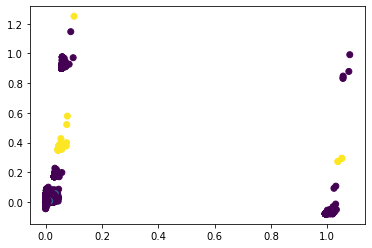

In [30]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1], c=reduced_df["cluster_full"])

In [32]:
for cluster,cluster_group in reduced_df.groupby("cluster_full"):
    print("Cluster:", cluster)
    
    sample_size = min(cluster_group.shape[0], 20)
    
    genre_counter = {}
    actor_counter = {}
    print("\t", "Movie Sample:")
    
    print_limit = 10
    for m in cluster_group.sample(n=sample_size).itertuples():
        if print_limit > 0:
            print("\t\t", m[0])
        print_limit -= 1
        
        this_movie_match = [movie for movie in movie_actor_list if movie["movie"] == m[0]]
        for movie in this_movie_match:
            for g in movie["genres"]:
                genre_counter[g] = genre_counter.get(g, 0) + 1
            for g in movie["actors"]:
                actor_counter[g] = actor_counter.get(g, 0) + 1
    
    print("\t", "Genres:")
    for g in sorted(genre_counter, key=genre_counter.get, reverse=True)[:10]:
        print("\t\t", g, genre_counter[g])
    print("\t", "Actors:")
    for a in sorted(actor_counter, key=actor_counter.get, reverse=True)[:10]:
        print("\t\t", actor_id_to_name_map[a], actor_counter[a])
    



Cluster: 0
	 Movie Sample:
		 Chrysanthemum to the Beast
		 The Moustache
		 Holidays by the Sea
		 Hatchet II
		 Learning the Ropes
		 Malang
		 Road to the Ghost Horse
		 Kiss of the Damned
		 Over the Moon
		 The Shaggy Dog
	 Genres:
		 Drama 21
		 Comedy 10
		 Action 6
		 Crime 5
		 Romance 4
		 Mystery 3
		 Horror 3
		 Documentary 2
		 Adventure 2
		 Fantasy 2
	 Actors:
		 Jack Kao 1
		 Suet Lam 1
		 Jaycee Chan 1
		 Ricky Chan 1
		 Yiheng Du 1
		 Hippolyte Girardot 1
		 Mathieu Amalric 1
		 Vincent Lindon 1
		 François Damiens 1
		 François Morel 1
Cluster: 1
	 Movie Sample:
		 Prayer Never Fails
		 Reach
		 Pirate Camp
		 A Bennett Song Holiday
		 The Christmas Project Reunion
		 Rust
		 The Last Straw
		 First Lady
		 Dead Air
		 Delicate Instruments
	 Genres:
		 Drama 15
		 Comedy 9
		 Thriller 7
		 Action 5
		 Family 5
		 Romance 4
		 Horror 4
		 Sci-Fi 2
		 Mystery 2
		 Crime 2
	 Actors:
		 Corbin Bernsen 20
		 Lorenzo Lamas 1
		 Eric Roberts 1
		 Idowu Adeyemi 1
		 Garrett 

## Finding a Good k-Value

In the 2D viz above, we might see a reasonable value of k via inspection.

Alternatively, we can use optimization and find a value of k that gives the "best" score.

Here, we use the `silhouette` coefficient for this task.

In [33]:
from sklearn.metrics import silhouette_score

In [34]:
model = KMeans(n_clusters=k)

model.fit(matrix_reduced)

KMeans(n_clusters=4)

In [37]:
# We can calculate the silhouette score for any clustering
silhouette_score(matrix_reduced, model.labels_)

0.9698787529433737

In [42]:
# Can even calculate it with totally random labels
random_labels = np.random.randint(0, k, matrix_reduced.shape[0])
silhouette_score(matrix_reduced, random_labels)

-0.08244831895928677

In [50]:
# Let us test different values of k
silhouette_scores = []
for test_k in range(2, 32, 2):
    print(test_k)
    
    tmp_model = KMeans(n_clusters=test_k)
    tmp_model.fit(matrix_reduced)
    
    score = silhouette_score(matrix_reduced, tmp_model.labels_)
    silhouette_scores.append((test_k, score))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


In [51]:
silhouette_df = pd.DataFrame(silhouette_scores, columns=["k", "score"])
silhouette_df

,k,score
0,2,0.979594
1,4,0.969879
2,6,0.957884
3,8,0.819264
4,10,0.794334
5,12,0.791663
6,14,0.784353
7,16,0.761067
8,18,0.765641
9,20,0.703721


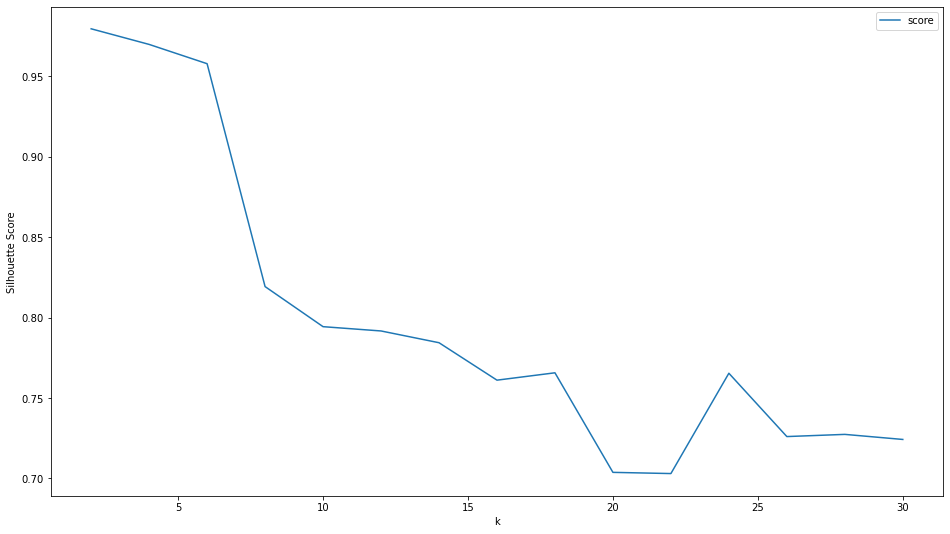

In [53]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

silhouette_df.plot("k", "score", ax=ax)

ax.set_ylabel("Silhouette Score")

plt.show()

# Should see a maximal silhouette score with a low value of k

## Elbow Method

Alternatively, we can evaluate how different the clusters become with increasing values of k and find the "elbow" point where clusters don't change much.

k-Means tracks a useful metric here, called `inertia`, or the sum of distances over all samples in a cluster to their closest cluster center.


In [55]:
# Let us test different values of k
interia_scores = []
for test_k in range(2, 32, 2):
    print(test_k)
    
    tmp_model = KMeans(n_clusters=test_k)
    tmp_model.fit(matrix_reduced)
    
    score = tmp_model.inertia_
    interia_scores.append((test_k, score))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


In [56]:
intertia_df = pd.DataFrame(interia_scores, columns=["k", "score"])
intertia_df

,k,score
0,2,101.733464
1,4,8.206721
2,6,2.409884
3,8,1.069809
4,10,0.717172
5,12,0.544501
6,14,0.424991
7,16,0.324445
8,18,0.259528
9,20,0.222669


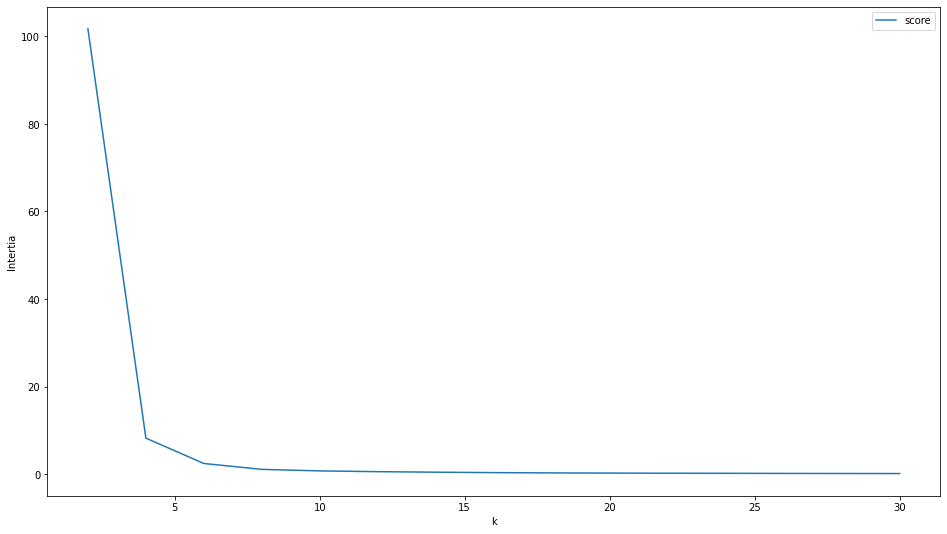

In [58]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

intertia_df.plot("k", "score", ax=ax)

ax.set_ylabel("Intertia")

plt.show()

# Should see an "elbow" in the data around a low value of k

## Elbow Method in Undreduced Space

We might expect a low value of k by inspecting the above 2D projections.

But what about in an unreduced space, where it's more difficult to visualize these samples?

Here, these optimization methods help us much more.

In [59]:
# Let us test different values of k
interia_scores = []
for test_k in range(2, 32, 2):
    print(test_k)
    
    tmp_model = KMeans(n_clusters=test_k)
    tmp_model.fit(matrix_sparse)
    
    score = tmp_model.inertia_
    interia_scores.append((test_k, score))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


In [60]:
intertia_df = pd.DataFrame(interia_scores, columns=["k", "score"])
intertia_df

,k,score
0,2,273660.111076
1,4,273598.709104
2,6,273611.258810
3,8,273538.338263
4,10,273505.018528
5,12,273507.923948
6,14,273435.073733
7,16,273327.618871
8,18,273281.939441
9,20,273315.094754


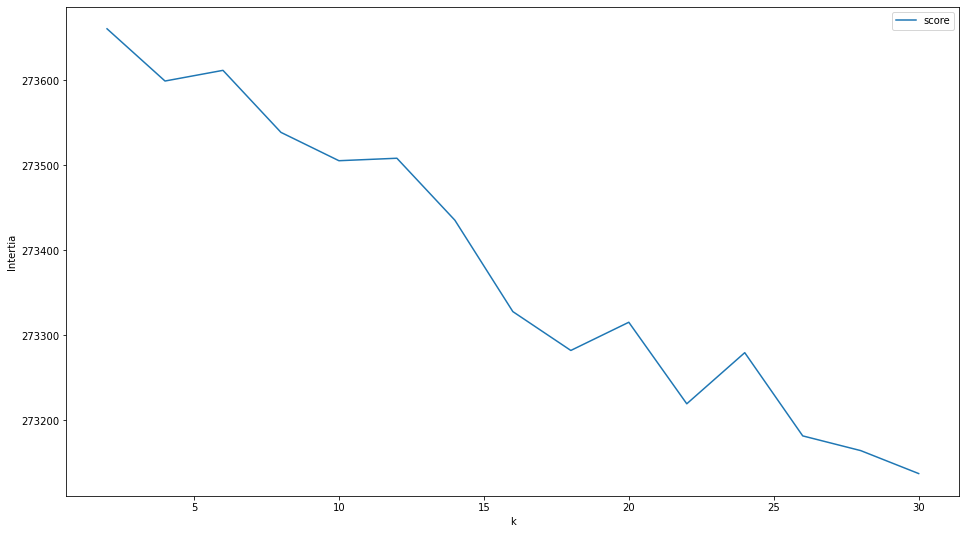

In [61]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

intertia_df.plot("k", "score", ax=ax)

ax.set_ylabel("Intertia")

plt.show()

# No clear elbow here, so we need to increase the spread in our possible k values

In [ ]:
## redo clustering with random k values

# Let us test different values of k
interia_scores = []
for test_k in set(np.random.randint(32,256,20)):
    print(test_k)
    
    tmp_model = KMeans(n_clusters=test_k)
    tmp_model.fit(matrix_sparse)
    
    score = tmp_model.inertia_
    interia_scores.append((test_k, score))

133
147
148
154
158
42
184


In [ ]:
intertia_df = pd.DataFrame(interia_scores, columns=["k", "score"])
intertia_df

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

intertia_df.plot("k", "score", ax=ax)

ax.set_ylabel("Intertia")

plt.show()

# No clear elbow here, so we need to increase the spread in our possible k values